In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



# PREPROCESO DE LOS DATOS

La siguiente función de preproceso hará lo siguiente con cada archivo


1) Vamos a eliminar aquellas columnas que tengan más de un 90% de datos faltantes. Hacemos esto porque son columnas que apenas van a aportar al modelo de clasificación, lo que permite simplificarlo sin perder precisión. 


2) Tratamos con los valores nulos, para ello vemos al usuario, si le falta datos en una columna categórica se pondrá el que más aparece y si es una numérica la media. 


3) Ahora analizamos los datos de tipo categórico. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Luego vemos que las columnas Infraction_CLH, Base_67254 y Infraction_TEN apesar de ser categóricos tienen un significado ordinal, por lo que podemos usar labelEncoding.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Por último las columnas Infraction_YFSG e Infraction_DQLY al no tener un valor ordinal y tener solo pocos valores disponibles, le aplicaremos one-hot-encoding.



4) Haremos un groupby por índice, así tendremos una linea por usuario, para tratar con sus datos, sumaremos los True de las columnas que hemos creado con one-hot-encoding y para el resto simplemento haremos la media.


5) Normalizamos los valores para que le sea más fácil al modelo aprender

Se ha analizado cardinalidad, sesgo y duplicados y se ha visto necesario incluirlo en el preprocesado

Además, a la hora de hacer el read tendremos en cuenta los tipos de datos de cada columna, quitando la necesidad de cargar el dataset y optimizarlos después. También se ha eliminado Expenditure_AHF, que indica la fecha en la que se ha realizado una transacción, que se ha decidido no dar importancia. En vez de analizar la temporalidad, los modelos se centran en analizar los parámetros que describen las transacciones de un usuario.

In [39]:
def preproceso(X):    
    # 1) 
    nulos = X.isnull().sum() >= 0.9*X.shape[0]
    nulos_a_eliminar = nulos[nulos].index
    X.drop(nulos_a_eliminar, axis=1, inplace=True)


    # 2) 
    X_num = X.select_dtypes(include = np.number)
    X_obj = X.select_dtypes(exclude = np.number)

    aux1 = X_num.isnull().sum() > 0
    X[aux1[aux1].index] = X[aux1[aux1].index].fillna(X[aux1[aux1].index].mean())
    aux2 = X_obj.isnull().sum() > 0
    X[aux2[aux2].index] = X[aux2[aux2].index].fillna(X[aux2[aux2].index].mode())

    # 3) 
    label = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']
    one_hot = ['Infraction_YFSG', 'Infraction_DQLY']

    X = pd.get_dummies(X, columns=one_hot)
    le = LabelEncoder()
    for col in label:
        X[col] = le.fit_transform(X[col])
        
    # 4)
    X.set_index('ID', inplace=True)
    X = pd.concat([X.select_dtypes(include='number').groupby('ID').mean() ,X.select_dtypes(include='bool').groupby('ID').sum()], axis = 1)


    # 5)
    X = (X - X.min()) / (X.max() - X.min())
    return X

In [ ]:
cols = pd.read_csv('../ML_24_25_PR1_train_and_test/train_data.csv', nrows = 100)
cols.drop('Expenditure_AHF', axis=1, inplace=True)
idx1, idx2 = cols.select_dtypes(include=np.number).columns, cols.select_dtypes(exclude=np.number).columns
cols[idx1], cols[idx2] = cols[idx1].apply(pd.to_numeric, downcast='float'), cols[idx2].apply(pd.Categorical)
train_data_dtypes = dict(zip(list(cols),['string']+[cols[x].dtype.name for x in cols.drop('ID', axis=1)]))

train_data = pd.read_csv('../ML_24_25_PR1_train_and_test/train_data.csv', dtype=train_data_dtypes, usecols=cols.columns)

In [40]:
X = preproceso(train_data)
y = pd.read_csv('../ML_24_25_PR1_train_and_test/train_labels.csv', index_col=['ID'])
df = pd.concat([X, y], axis=1)
df.to_csv('df.csv')

Graficamos el mapa de correlación para poder compararlo luego una vez realizado la selección de característica.

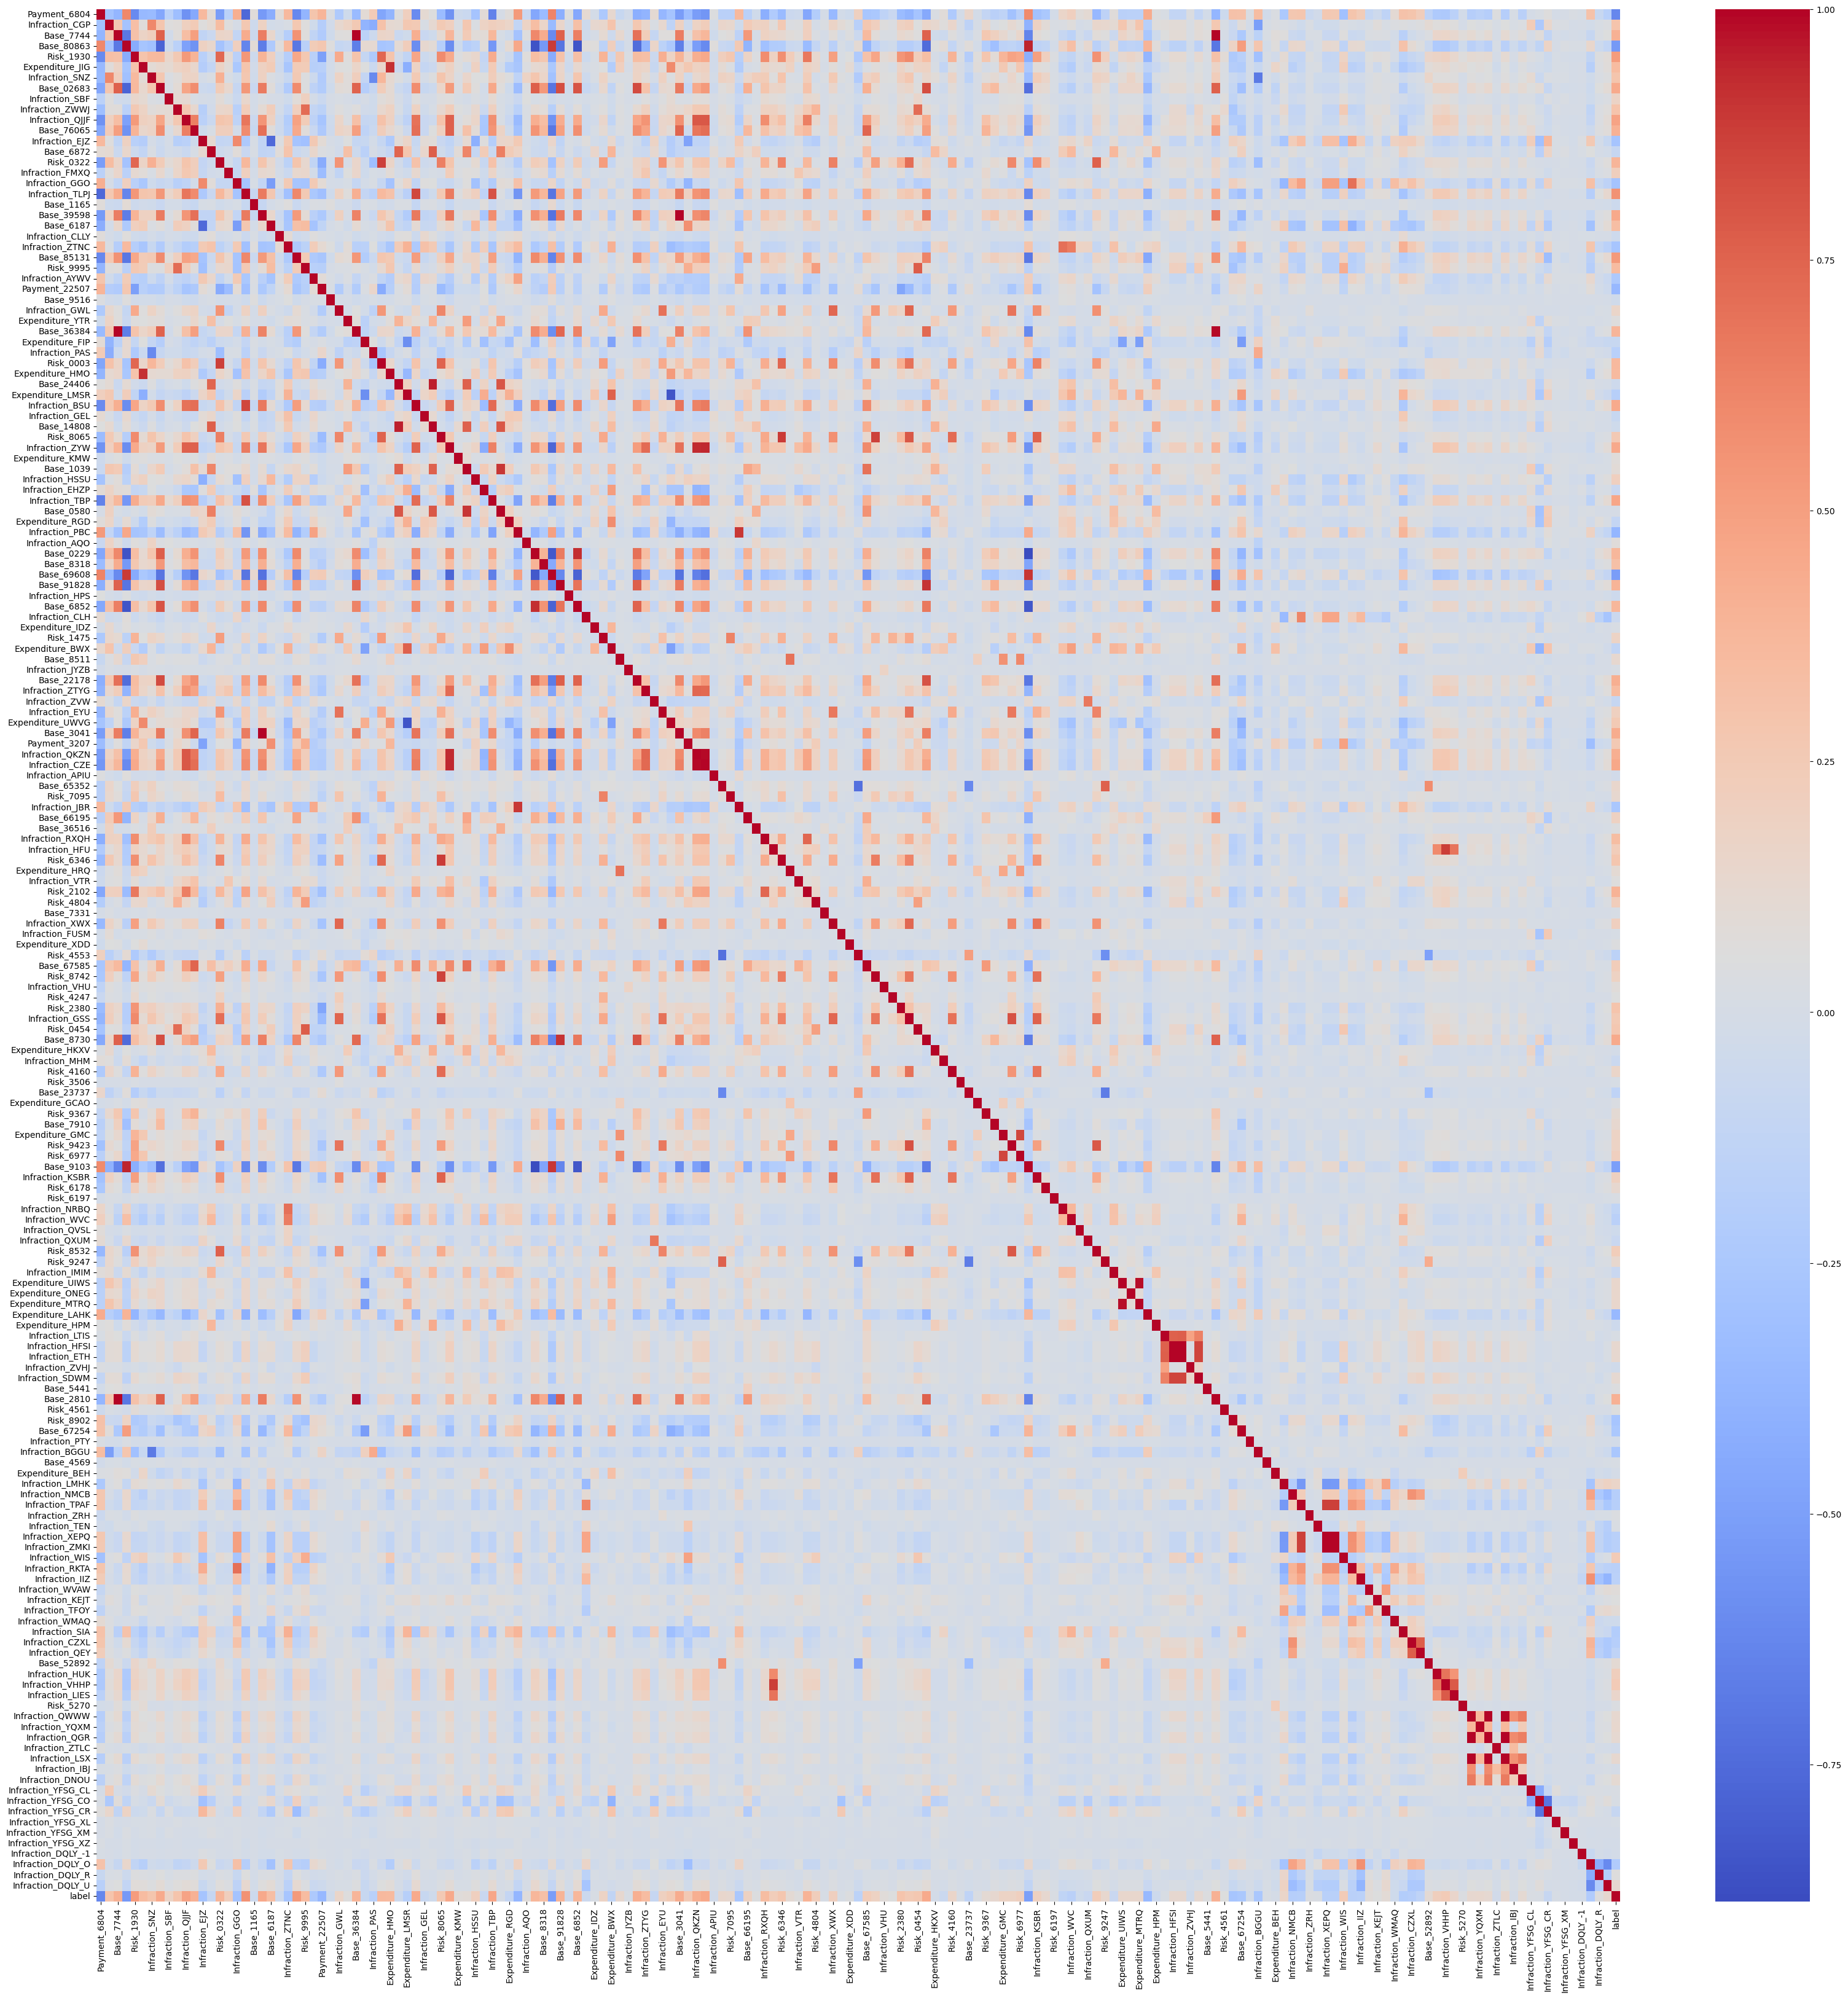

In [41]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

# TRATAMIENTO DE DATOS DESBALANCEADOS

Verificamos si tenemos datos desbalanceados y nos encontramos con una proporción algo mayor que el 1/3. Por ello, realizaremos oversampling con SMOTE para aumentar el número de casos con los datos minoritarios. Mantendremos y trabajaremos con estos dos nuevos datasets y luego veremos cual de los dos nos devuelve mejores resultados.

In [ ]:
display(df.label.value_counts())

smote = SMOTE(random_state=42)
X_, y_ = df.drop('label', axis=1), df.label
X_over, y_over = smote.fit_resample(X_, y_)

df_over = pd.concat([X_over, y_over], axis=1)

df_over.label.value_counts()
df_over.to_csv('df_over.csv')

label
0    203889
1     71458
Name: count, dtype: int64

label
1    203889
0    203889
Name: count, dtype: int64

# SELECCIÓN DE CARACTERÍSTICA

Crearemos 4 funciones para seleccionar las columnas importantes.

La primera consistirá en un análisis manual imponiendo umbrales para algunas características como: correlación entre columnas mayor que x, número de NANs en la columna...

El segundo usará métodos del filtro, en específico: VarianceThreshold

El tercero usará métodos de wrapper, en específico usaremos los siguientes modelos:

El cuarto usará métodos de embeddings, en específico:

In [43]:
def FS1(df):
    df_aux = df.copy()
    n = 0
    
    # eliminamos la columna si tiene una correlación alta con otras
    corr = df_aux.corr().fillna(0)
    aux = np.abs(corr) > 0.8
    indices_filas, indices_columnas = np.where(aux)
    parecido_a_eliminar = [corr.columns[col] for row, col in zip(indices_filas, indices_columnas)\
                            if row != col and (row + col) < 2 * row]
    df_aux.drop(parecido_a_eliminar, axis=1, inplace=True)

    # eliminamos la columna si su correlación con la etiqueta es muy baja
    corr = corr['label'].drop(parecido_a_eliminar)
    aux = np.abs(corr) < 0.1
    indices = np.where(aux)
    poco_importante = corr.index[indices]
    df_aux.drop(poco_importante, axis=1, inplace=True)

    # eliminamos las columnas si tienen un valor que represente el 80% de los datos
    sobre_representado_a_eliminar = [col for col in df_aux.columns \
                                     if df_aux[col].value_counts().iloc[0] >= 0.8*df.shape[0]]
    df_aux.drop(sobre_representado_a_eliminar, axis=1, inplace=True)

    n += len(parecido_a_eliminar) + len(poco_importante) + len(sobre_representado_a_eliminar)
    cols_eliminadas = parecido_a_eliminar + poco_importante.tolist() + sobre_representado_a_eliminar

    print(f'Se ha eliminado {n} columnas con métodos de selección manual, específicamente: {cols_eliminadas}')
    return df_aux

df1 = FS1(df)
df1_over = FS1(df_over)

df1.to_csv('df1.csv')
df1_over.to_csv('df1_over.csv')

Se ha eliminado 104 columnas con métodos de selección manual, específicamente: ['Base_7744', 'Risk_0322', 'Expenditure_JIG', 'Infraction_TLPJ', 'Base_24406', 'Infraction_TLPJ', 'Base_24406', 'Base_1039', 'Base_80863', 'Base_80863', 'Base_0229', 'Base_02683', 'Base_80863', 'Base_02683', 'Base_0229', 'Base_02683', 'Expenditure_LMSR', 'Base_39598', 'Infraction_ZYW', 'Infraction_ZYW', 'Infraction_QKZN', 'Infraction_PBC', 'Risk_8065', 'Risk_8065', 'Base_02683', 'Base_91828', 'Base_22178', 'Infraction_GSS', 'Expenditure_GMC', 'Base_80863', 'Base_0229', 'Base_69608', 'Base_6852', 'Expenditure_UIWS', 'Infraction_HFSI', 'Infraction_HFSI', 'Infraction_ETH', 'Base_7744', 'Base_36384', 'Infraction_TPAF', 'Infraction_TPAF', 'Infraction_XEPQ', 'Infraction_HFU', 'Infraction_QWWW', 'Infraction_QWWW', 'Infraction_QGR', 'Base_6872', 'Base_1165', 'Infraction_CLLY', 'Base_9516', 'Expenditure_YTR', 'Expenditure_FIP', 'Infraction_GEL', 'Base_14808', 'Expenditure_KMW', 'Infraction_EHZP', 'Base_0580', 'Infrac

Se ha eliminado 110 columnas con umbral de varianza específicamente: ['Infraction_CLLY', 'Risk_8532', 'Base_24406', 'Risk_9247', 'Infraction_PTY', 'Infraction_EYU', 'Infraction_ZRH', 'Expenditure_HPM', 'Expenditure_JIG', 'Infraction_ZVW', 'Expenditure_BEH', 'Infraction_QJJF', 'Risk_4160', 'Infraction_HPS', 'Infraction_YFSG_XL', 'Infraction_VTR', 'Risk_8742', 'Infraction_PBC', 'Risk_1930', 'Base_1039', 'Base_52892', 'Base_65352', 'Infraction_ZTNC', 'Base_76065', 'Risk_0003', 'Infraction_ZTLC', 'Risk_8065', 'Risk_9423', 'Expenditure_HMO', 'Risk_2380', 'Infraction_APIU', 'Expenditure_XDD', 'Base_1165', 'Expenditure_UWVG', 'Infraction_HSSU', 'Infraction_VHU', 'Expenditure_UIWS', 'Expenditure_ONEG', 'Base_8511', 'Infraction_YFSG_XM', 'Infraction_SNZ', 'Base_0580', 'Infraction_GEL', 'Expenditure_GCAO', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_YFSG_XZ', 'Infraction_ZWWJ', 'Base_4569', 'Base_6872', 'Risk_3506', 'Risk_5270', 'Base_5441', 'Base_7744', 'Expenditure_HRQ', 'Risk_9995', 'In

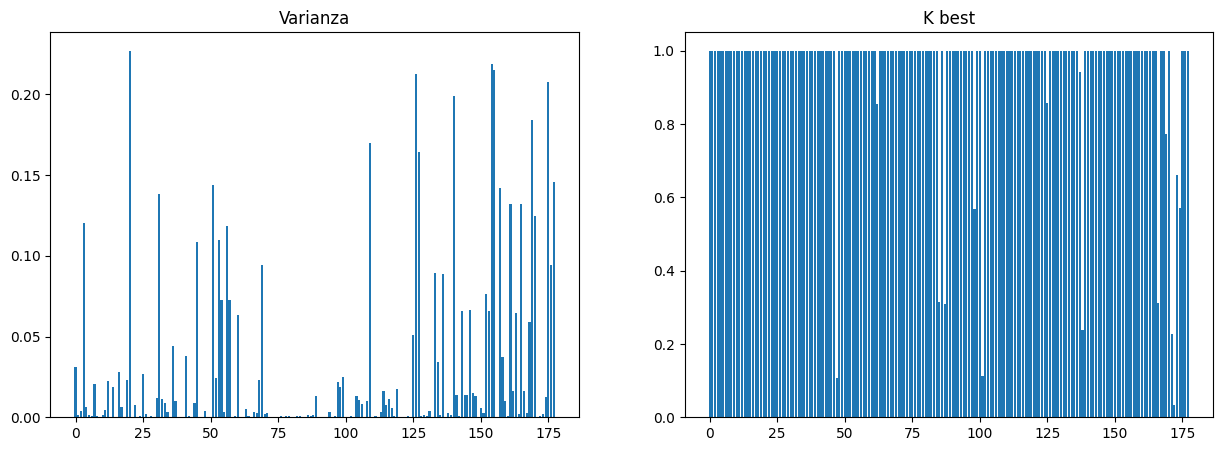

Se ha eliminado 108 columnas con umbral de varianza específicamente: ['Infraction_CLLY', 'Risk_8532', 'Base_24406', 'Risk_9247', 'Infraction_QXUM', 'Infraction_PTY', 'Infraction_EYU', 'Infraction_ZRH', 'Expenditure_HPM', 'Expenditure_JIG', 'Infraction_ZVW', 'Expenditure_BEH', 'Infraction_QJJF', 'Risk_4160', 'Infraction_HPS', 'Infraction_YFSG_XL', 'Infraction_VTR', 'Risk_8742', 'Infraction_PBC', 'Risk_1930', 'Base_1039', 'Base_52892', 'Base_65352', 'Infraction_ZTNC', 'Base_76065', 'Infraction_ZTLC', 'Risk_8065', 'Risk_9423', 'Expenditure_HMO', 'Risk_2380', 'Infraction_APIU', 'Expenditure_XDD', 'Base_1165', 'Expenditure_UWVG', 'Infraction_HSSU', 'Infraction_VHU', 'Expenditure_UIWS', 'Expenditure_ONEG', 'Base_8511', 'Infraction_YFSG_XM', 'Infraction_SNZ', 'Base_0580', 'Infraction_GEL', 'Expenditure_GCAO', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_YFSG_XZ', 'Infraction_ZWWJ', 'Base_4569', 'Base_6872', 'Risk_3506', 'Risk_5270', 'Base_5441', 'Base_7744', 'Expenditure_HRQ', 'Risk_9995

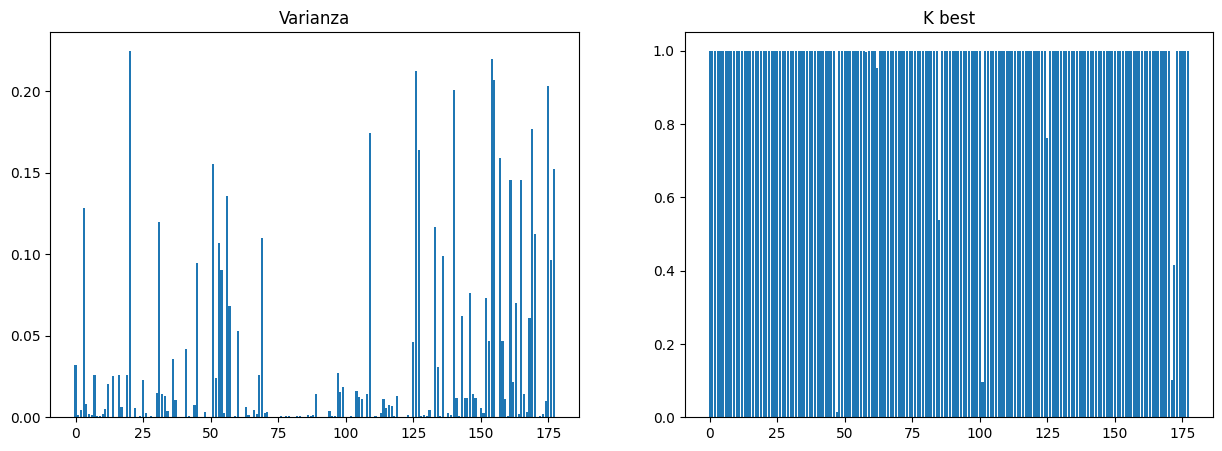

In [44]:
def FS2(df):
    df_aux = df.copy()
    X, y = df_aux.drop('label', axis=1), df_aux['label']
    
    #  Umbral de varianza
    var = VarianceThreshold().fit(X)
    puntuaje1 = var.variances_
    
    df_aux1 = pd.concat([X.loc[:, puntuaje1 > 0.01], y], axis=1)
    print(f'Se ha eliminado {df.shape[1] - df_aux1.shape[1]} columnas con umbral de varianza', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux1.columns))}')


    # Selección de características univariantes con K mejores
    selector = SelectKBest(f_classif).fit(X, y)
    epsilon = 10**(-20)
    puntuaje2 = -np.log10(selector.pvalues_ + epsilon)
    puntuaje2 /= (puntuaje2.max() + epsilon)

    df_aux2 = pd.concat([X.loc[:, puntuaje2 > 0.2], y], axis=1)
    print(f'Se ha eliminado {df.shape[1] - df_aux2.shape[1]} columnas con k mejores', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux2.columns))}')


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(puntuaje1.shape[0]), puntuaje1), plt.title(f'Varianza')
    plt.subplot(1, 2, 2)
    plt.title(f'K best'), plt.bar(np.arange(puntuaje2.shape[0]), puntuaje2)
    plt.show()

    return df_aux1, df_aux2

df2_1, df2_2 = FS2(df)
df2_1_over, df2_2_over = FS2(df_over)

df2_1.to_csv('df2_1.csv')
df2_2.to_csv('df2_2.csv')
df2_1_over.to_csv('df2_1_over.csv')
df2_2_over.to_csv('df2_2_over.csv')

In [ ]:
def FS3(df):
    modelos = {
        "lineal": LinearRegression(),
        "polinomial2": make_pipeline(PolynomialFeatures(2), LinearRegression()), # MEKE PIPELINE NO ES COMPATIBLE BUSCAR SOLUCION
        "polinomial3": make_pipeline(PolynomialFeatures(3), LinearRegression()), #
        "LogisticRegression": LogisticRegression(solver='saga', penalty='l2', max_iter=200, C=0.1, n_jobs=-1),
        "SGDClassifier": SGDClassifier(loss='hinge', penalty='l2', max_iter=200, alpha=0.0001, n_iter_no_change=10),
        "RandomForestClassifier": RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_split=20, min_samples_leaf=10, n_jobs=-1),
        "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=50), # MUY LARGO
        "AdaBoostClassifier": AdaBoostClassifier(n_estimators=200, learning_rate=0.1),
        "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=50, min_samples_split=20, min_samples_leaf=10, criterion='gini'),
        "kkn": KNeighborsClassifier(n_neighbors=5, algorithm='auto', metric='minkowski', p=2) # ERROR Y MUY LARGO
    }

    dfs = dict()

    for nombre, modelo in modelos.items():
        X, y = df.drop('label', axis=1), df['label']

        modelo.fit(X, y)
        selector = SelectFromModel(modelo, threshold="mean", prefit=True)
        n = selector.get_support()
        n_aux = np.where(n == 0, 1, 0)

        if hasattr(modelo, 'feature_importances_'):
            puntuaje = modelo.feature_importances_[n]
        elif modelo.coef_.ndim == 1:
            puntuaje = np.abs(modelo.coef_)[n]
        else:
            puntuaje = np.abs(modelo.coef_[0])[n]
        xs = np.arange(puntuaje.shape[0])

        plt.bar(xs, puntuaje), plt.title(nombre), plt.xlabel('columnas'), plt.ylabel('importancia') 
        plt.show()
        dfs[nombre] = pd.concat([X.loc[:, n], y], axis=1)

        print(f'Se ha eliminado {np.sum(n_aux)} columnas con {nombre}', end=' ')
        print(f'específicamente: {X.columns[n_aux].tolist()}')
    
    return dfs

df = pd.read_csv('df.csv', index_col=0)
df_over = pd.read_csv('df_over.csv', index_col=0)

df3 = FS3(df)
df3_over = FS3(df_over)


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KeyboardInterrupt: 